## Predicting Energy Consumption from PJM (in MW)

Will also be comparing energy consumption from the East and West Regions of the United States as well as their projected energy consumption.

#### Functions & Imports

In [1]:
import pandas as pd
import seaborn as sns
import plotly as plt
import scipy.optimize as sp
import math as m
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
def forecast_future_values(X_VALS, Y_VALS, periods=24, frq='MS'):
    '''
    Create a set of values predicted from an auto-regression model based on
    a given set of data.
    
    Input:
    X_VALS => list of x-values given
    Y_VALS => list of y-values given
    periods (Default: 24) => time alotted; each period (1) corresponds to the frequency input
    frq (Default: 'MS') => the frequency which observations are recorded
    '''
    # Convert X_VALS and Y_VALS to pandas series
    dates = pd.date_range(start='2002-01-01', periods=len(X_VALS), freq=frq)
    data = pd.Series(Y_VALS, index=dates)
    
    # Fit SARIMA model
    # Based on ACF and PACF plots, SARIMA(1,0,1)(1,1,1,12) is chosen
    model = SARIMAX(data, order=(1,0,1), seasonal_order=(1,1,1,12))
    results = model.fit()
    
    # Forecast future values
    forecast = results.forecast(steps=periods) # forecasting for specified num. of periods
    
    return forecast.tolist()

In [3]:
def newtint(x, y, xx):
    '''
    Function that uses a Newton Interpolating Polynomial
    Uses n-1 order polynomial given an n amount of data points to
    return a value of the dependent variable => yint at a provided
    independent variable => xx

    Input:
        x => array of independent variables
        y => array of dependent variables
        xx => desired x-value to interpolate

    Output:
        yint => interpolated value at xx
    '''

    # Check if the data is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length.'

    # Initialize holder for calculations -> used to fill with dependent variables
    b = np.zeros((n, n))
    # Assign dependent variables to the 1st column of b for all rows in that column
    b[:, 0] = np.transpose(y)  # switch from input row to input column in b

    # Looping through each value in array to calculate the divided differences
    for j in range(1, n):
        for i in range(n-j):
            # Equation for divided differences based on next and prev points (see slides)
            b[i, j] = (b[i+1, j-1] - b[i, j-1]) / (x[i+j] - x[i])

    xt = 1
    yint = b[0, 0]

    # Solves for yint based on xx and divided differences
    for j in range(n-1):
        xt *= (xx - x[j])
        yint += b[0, j+1] * xt

    return yint

In [4]:
def lagrange(x, y, xx):
    '''
    Lagrange Interpolating Polynomial
    Uses n-1 order lagrange interpolating polynomial based on n number of data points to 
    return a value of the dependent variable yint given the independent variable xx

    Input:
        x => array of independent variable values
        y => array of dependent variable values
        xx => desired independent variable to interpolate

    Output:
        yint => interpolated value
    '''

    # Checking to see if everything is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length'

    # Creating a placeholder
    s = 0

    for i in range(n):
        product = y[i]

        for j in range(n):
            if i != j:
                # This is the weighting equation => L (see slides)
                product *= (xx - x[j]) / (x[i] - x[j])
        s += product

    yint = s
    return yint

In [5]:
# Importing the csv files and assigning them as dataframes
dfw = pd.read_csv('PJMW_hourly.csv')
dfe = pd.read_csv('PJME_hourly.csv')

#### West-region

In [12]:
# Setting values to floats for 'PJMW_MW'
pd.to_numeric(dfw['PJMW_MW'])

used_year_month = [] # Creating list of already used months per year
used_year = [] # Creating list of already used years
year_month = 0 # init the year_month iter var
year_only = 0 # init the year_only iter var

PJMW_per_month = [] # tmp list for averaging PJMW_MW vals per month
PJMW_per_year = [] # tmp list for collecting PJMW vals in one whole year for avg
avg_per_year_month = [] # avg PJMW vals per month
avg_per_year = [] # avg PJMW vals per year

tmp_avg = 0 # tmp avg for years only

# Looping through 'dfw' to sort the data by year and month and create model
for row in dfw.itertuples():
    year_month = row[1][0:7] # ind1 -> tuple key | ind2 -> tuple value
    if year_month in used_year_month: # checks if current year-mnth in list
        PJMW_per_month.append(row[2]) # appends that PJMW value
    elif year_month not in used_year_month: # checks for start of new year
        if not used_year_month: # check for start of loop
            used_year_month.append(year_month) # appends curr year to usedYears list
            continue
        used_year_month.append(year_month) # appends curr year to usedYears list
        tmpAVG = np.average(PJMW_per_month) # averages PJMW vals per year before clearing valsPJMW
        avg_per_year_month.append(round(tmpAVG, 0))
        PJMW_per_month.clear() # clears PJMW vals for new year

# Looping through 'dfw' to sort the data by year only and create model
for row in dfw.itertuples():
    year_only = row[1][0:4] # ind1 -> tuple key | ind2 -> tuple value
    if year_only in used_year:
        PJMW_per_year.append(row[2])
    elif year_only not in used_year: # checks for start of new year
        if not used_year: # check for start of loop
            used_year.append(year_only) # appends curr year to usedYears list
            continue
        used_year.append(year_only) # appends curr year to usedYears list
        tmp_avg = np.average(PJMW_per_year) # averages PJMW vals per year before clearing valsPJMW
        avg_per_year.append(round(tmpAVG, 0))
        PJMW_per_year.clear() # clears PJMW vals for new year
    
# Global CONSTANT for length of used_year_month to keep consistancy for future arrays
array_len_ym_const = len(used_year_month)
# Global CONSTANT for length of used_year to keep consistancy for future arrays
array_len_y_const = len(used_year)

years_months_list = [] # list of years with dec. for months used for graphing

years_list_curr_val = int(dfw['Datetime'][0][0:4]) # sets current year value to 2002
for i in range(array_len_ym_const): # loops through length of array_length_const
    years_months_list.append(round(years_list_curr_val, 2)) # appends to the list for graphing
    years_list_curr_val += 1 / 12 # math to add onto the list evenly
years_months_list.pop(-1) # removes last value from years_months_list (extra created from loop)

used_year.pop(-1) # removes last value from years_list

'2018'

Regression, Interpolation, and Visualization

In [34]:
x_Years_Months = np.array(years_months_list)
y_PJMW_YM = np.array(avg_per_year_month)

x_Years = np.array(used_year)
y_PJMW_Y = np.array(avg_per_year)

In [54]:
start_year = 2018 # year to start regression from
end_year = start_year + 16 # creating a regression of 17 years
end_year_months = start_year + 2 # year to end regression
new_year = []
for i in range(end_year - start_year):
    new_year.append(start_year + i)
new_years_months = np.linspace(start_year, end_year_months, 24) # year values as list

In [47]:
regr_avg_per_year = forecast_future_values(used_year, avg_per_year, periods=16, frq='AS')
regr_avg_per_year_month = forecast_future_values(years_months_list, avg_per_year_month, periods=24, frq='MS')

c:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
y = np.concatenate( # y-vals of graph -> PJMWs
    (avg_per_year_month, regr_avg_per_year_month),
    axis=0)

x = np.concatenate( # x-vals of graph -> Years
    (x_Years_Months, new_years_months),
    axis=0
)

# Creating dictionary of labeled columns
yr_m_v_pjmw = {'Title':'PJM Energy Production from 2002 to 2020',
             'Year':x, 
             'PJMW':y}

plotDF = pd.DataFrame(yr_m_v_pjmw) # creating dataframe from dictionary for plotting

In [55]:
yy = np.concatenate(
    (avg_per_year, regr_avg_per_year),
    axis=0
)

xx = np.concatenate(
    (x_Years, new_year),
    axis=0
)

yr_v_pjmw = {'Year':xx,
             'PJMW':yy}

plotDF2 = pd.DataFrame(yr_v_pjmw)
plotDF2

,Year,PJMW
0,2002,5974.0
1,2003,5974.0
2,2004,5974.0
3,2005,5974.0
4,2006,5974.0
5,2007,5974.0
6,2008,5974.0
7,2009,5974.0
8,2010,5974.0
9,2011,5974.0


<Axes: xlabel='Year', ylabel='PJMW'>

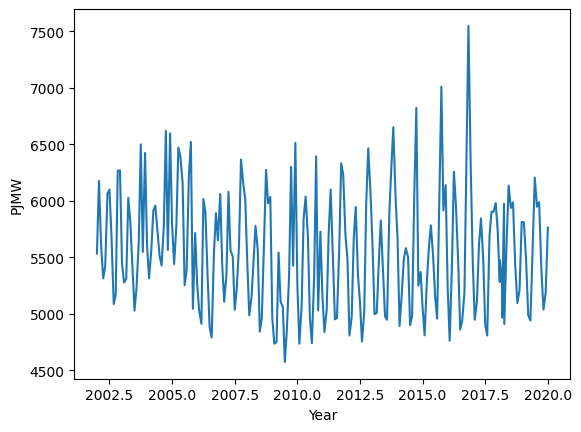

In [37]:
sns.lineplot(data=plotDF,
             x='Year',
             y='PJMW')

<Axes: xlabel='Year', ylabel='PJMW'>

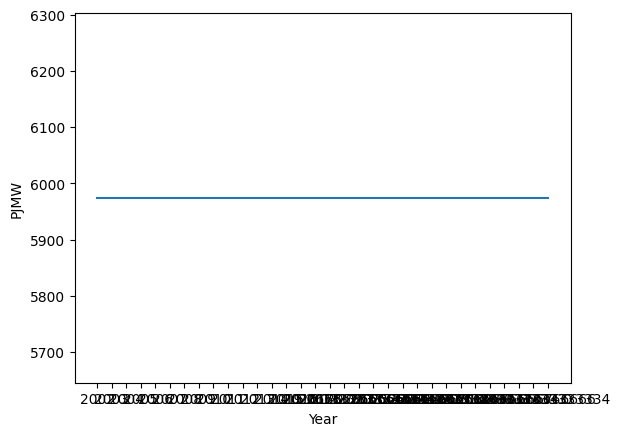

In [41]:
sns.lineplot(data=plotDF2,
             x='Year',
             y='PJMW')

#### East-region

In [ ]:
# Using numerical methods to create a model from each dataset
